In [5]:
import numpy as np
import math
import os
import tensorflow as tf
import keras
import keras.backend as K

In [6]:
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout,Flatten,Concatenate, Masking
from keras.layers import LSTM
from sklearn.model_selection import train_test_split

In [7]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True

# Limit the maximum memory used
config.gpu_options.per_process_gpu_memory_fraction = 0.9

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [8]:
def mse_multiDim_loss(y_true, y_pred):
    return K.mean(K.sum(K.square(y_true - y_pred),axis = -1, keepdims=True))

In [27]:
distance_frmMonitor = 70 #in cm
ScreenWidth = 60.77 #cms excluding bezel width
dispHoriRes = 2560
display = np.array([2560,1440])

deg_per_px = math.degrees(math.atan2(.5*ScreenWidth, distance_frmMonitor)) / (.5*dispHoriRes)

def visualDeg_err(y_true, y_pred):
    y_true_temp = y_true * display
    y_pred_temp = y_pred * display
    return (K.mean(K.sqrt(K.sum(K.square(y_true_temp - y_pred_temp), axis=-1, keepdims=True))) * deg_per_px)

In [11]:
#input data
data_dir = "/home/niteesh/Documents/uni/HCI/Saarland/Npy_files/"
files = os.listdir(data_dir)
#for f in files:
#   file = data_dir + f
#    if f== files[0]:
#        data = np.load(file)
#    else:
#        data = np.vstack((data,np.load(file)))
        
data = np.load(data_dir + "9.npy")
print(data.shape)

(771, 11, 3)


In [28]:
#Hyper-parameters, constants
max_length_saccades = 6
learning_rate=0.0009
decay_rate = 1e-6

In [29]:
#format data
Input = data[:,0:max_length_saccades,:]
#y = data[:,-1,:]
y = data[:,-1,0:2]
print(Input.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(Input, y, test_size=0.33)


(771, 6, 3)
(771, 2)


In [30]:
optimizer = keras.optimizers.Adam(lr=learning_rate,decay=decay_rate)
model = keras.models.Sequential()

#layer1 = model.add(Masking(mask_value=np.inf, input_shape=(max_length_saccades, 3),name = 'mask_layer'))

layer2 = model.add(LSTM(32, return_sequences=True, input_shape=(max_length_saccades, 3)))

#model.add(Dropout(0.2))

layer3 = model.add(LSTM(32,return_sequences=False,))  
# returns a sequence of vectors of dimension 32

#model.add(Dropout(0.2))



#layer4 = model.add(Dropout(0.2))
#model.add(Flatten())

#model.add(Dense(16, activation='relu'))

output_layer = model.add(Dense(2, activation='linear',name = 'output_layers'))
#output_layer = model.add(LSTM(2,activation=None,return_sequences=False)) 

# try using different optimizers and different optimizer configs
#model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])

model.compile(loss=mse_multiDim_loss,
              optimizer=optimizer,
              metrics=[visualDeg_err])
# Print summary
model.summary()
print("Inputs: {}".format(model.input_shape))
print("Outputs: {}".format(model.output_shape))
print("Actual input: {}".format(Input.shape))
print("Actual output: {}".format(y.shape))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 6, 32)             4608      
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
output_layers (Dense)        (None, 2)                 66        
Total params: 12,994
Trainable params: 12,994
Non-trainable params: 0
_________________________________________________________________
Inputs: (None, 6, 3)
Outputs: (None, 2)
Actual input: (771, 6, 3)
Actual output: (771, 2)


In [37]:
#Fit the model to data
history = model.fit(x = Input, y= y, batch_size= 32, epochs = 500, verbose = 1, validation_split = 0.1, shuffle = True  )

Train on 693 samples, validate on 78 samples
Epoch 1/500
693/693 [==============================] - 0s 610us/step - loss: 0.0325 - visualDeg_err: 5.0943 - val_loss: 0.0650 - val_visualDeg_err: 7.1005
Epoch 2/500
693/693 [==============================] - 0s 616us/step - loss: 0.0348 - visualDeg_err: 5.3431 - val_loss: 0.0674 - val_visualDeg_err: 7.3970
Epoch 3/500
693/693 [==============================] - 0s 684us/step - loss: 0.0352 - visualDeg_err: 5.3774 - val_loss: 0.0581 - val_visualDeg_err: 6.8694
Epoch 4/500
693/693 [==============================] - 0s 687us/step - loss: 0.0364 - visualDeg_err: 5.3547 - val_loss: 0.0652 - val_visualDeg_err: 7.3996
Epoch 5/500
693/693 [==============================] - 0s 692us/step - loss: 0.0324 - visualDeg_err: 5.0661 - val_loss: 0.0582 - val_visualDeg_err: 6.7377
Epoch 6/500
693/693 [==============================] - 0s 702us/step - loss: 0.0319 - visualDeg_err: 4.9303 - val_loss: 0.0611 - val_visualDeg_err: 6.9054
Epoch 7/500
693/693 [====

693/693 [==============================] - 0s 553us/step - loss: 0.0309 - visualDeg_err: 4.9460 - val_loss: 0.0568 - val_visualDeg_err: 6.5271
Epoch 54/500
693/693 [==============================] - 0s 521us/step - loss: 0.0344 - visualDeg_err: 5.3411 - val_loss: 0.0658 - val_visualDeg_err: 7.1138
Epoch 55/500
693/693 [==============================] - 0s 519us/step - loss: 0.0310 - visualDeg_err: 4.9779 - val_loss: 0.0567 - val_visualDeg_err: 6.7440
Epoch 56/500
693/693 [==============================] - 0s 522us/step - loss: 0.0306 - visualDeg_err: 4.8838 - val_loss: 0.0561 - val_visualDeg_err: 6.5221
Epoch 57/500
693/693 [==============================] - 0s 510us/step - loss: 0.0298 - visualDeg_err: 4.7564 - val_loss: 0.0608 - val_visualDeg_err: 6.7957
Epoch 58/500
693/693 [==============================] - 0s 483us/step - loss: 0.0326 - visualDeg_err: 5.0489 - val_loss: 0.0699 - val_visualDeg_err: 7.4818
Epoch 59/500
693/693 [==============================] - 0s 536us/step - loss:

693/693 [==============================] - 0s 526us/step - loss: 0.0330 - visualDeg_err: 5.2524 - val_loss: 0.0706 - val_visualDeg_err: 7.8276
Epoch 106/500
693/693 [==============================] - 0s 510us/step - loss: 0.0320 - visualDeg_err: 5.0062 - val_loss: 0.0584 - val_visualDeg_err: 6.8304
Epoch 107/500
693/693 [==============================] - 0s 526us/step - loss: 0.0296 - visualDeg_err: 4.7990 - val_loss: 0.0625 - val_visualDeg_err: 7.0848
Epoch 108/500
693/693 [==============================] - 0s 514us/step - loss: 0.0302 - visualDeg_err: 4.9030 - val_loss: 0.0640 - val_visualDeg_err: 7.2274
Epoch 109/500
693/693 [==============================] - 0s 516us/step - loss: 0.0301 - visualDeg_err: 4.8753 - val_loss: 0.0580 - val_visualDeg_err: 7.0117
Epoch 110/500
693/693 [==============================] - 0s 514us/step - loss: 0.0273 - visualDeg_err: 4.6083 - val_loss: 0.0571 - val_visualDeg_err: 6.6204
Epoch 111/500
693/693 [==============================] - 0s 521us/step -

693/693 [==============================] - 0s 513us/step - loss: 0.0292 - visualDeg_err: 4.8004 - val_loss: 0.0575 - val_visualDeg_err: 6.5689
Epoch 158/500
693/693 [==============================] - 0s 586us/step - loss: 0.0316 - visualDeg_err: 5.0852 - val_loss: 0.0603 - val_visualDeg_err: 7.1420
Epoch 159/500
693/693 [==============================] - 0s 615us/step - loss: 0.0320 - visualDeg_err: 5.1542 - val_loss: 0.0583 - val_visualDeg_err: 6.6844
Epoch 160/500
693/693 [==============================] - 0s 546us/step - loss: 0.0280 - visualDeg_err: 4.6362 - val_loss: 0.0655 - val_visualDeg_err: 7.1354
Epoch 161/500
693/693 [==============================] - 0s 659us/step - loss: 0.0269 - visualDeg_err: 4.5441 - val_loss: 0.0633 - val_visualDeg_err: 7.0669
Epoch 162/500
693/693 [==============================] - 0s 635us/step - loss: 0.0289 - visualDeg_err: 4.7875 - val_loss: 0.0638 - val_visualDeg_err: 7.1927
Epoch 163/500
693/693 [==============================] - 0s 593us/step -

693/693 [==============================] - 0s 572us/step - loss: 0.0280 - visualDeg_err: 4.7459 - val_loss: 0.0596 - val_visualDeg_err: 6.9279
Epoch 210/500
693/693 [==============================] - 0s 570us/step - loss: 0.0275 - visualDeg_err: 4.5994 - val_loss: 0.0616 - val_visualDeg_err: 6.9648
Epoch 211/500
693/693 [==============================] - 0s 511us/step - loss: 0.0281 - visualDeg_err: 4.6856 - val_loss: 0.0637 - val_visualDeg_err: 7.2189
Epoch 212/500
693/693 [==============================] - 0s 557us/step - loss: 0.0304 - visualDeg_err: 4.9381 - val_loss: 0.0617 - val_visualDeg_err: 7.0470
Epoch 213/500
693/693 [==============================] - 0s 579us/step - loss: 0.0283 - visualDeg_err: 4.7809 - val_loss: 0.0638 - val_visualDeg_err: 6.9753
Epoch 214/500
693/693 [==============================] - 0s 552us/step - loss: 0.0274 - visualDeg_err: 4.6323 - val_loss: 0.0673 - val_visualDeg_err: 7.2680
Epoch 215/500
693/693 [==============================] - 0s 524us/step -

693/693 [==============================] - 0s 484us/step - loss: 0.0242 - visualDeg_err: 4.3734 - val_loss: 0.0608 - val_visualDeg_err: 6.9548
Epoch 262/500
693/693 [==============================] - 0s 514us/step - loss: 0.0283 - visualDeg_err: 4.8015 - val_loss: 0.0696 - val_visualDeg_err: 7.7947
Epoch 263/500
693/693 [==============================] - 0s 510us/step - loss: 0.0314 - visualDeg_err: 4.9506 - val_loss: 0.0623 - val_visualDeg_err: 7.1502
Epoch 264/500
693/693 [==============================] - 0s 522us/step - loss: 0.0259 - visualDeg_err: 4.5221 - val_loss: 0.0597 - val_visualDeg_err: 6.8939
Epoch 265/500
693/693 [==============================] - 0s 553us/step - loss: 0.0263 - visualDeg_err: 4.4849 - val_loss: 0.0565 - val_visualDeg_err: 6.7837
Epoch 266/500
693/693 [==============================] - 0s 526us/step - loss: 0.0298 - visualDeg_err: 4.8796 - val_loss: 0.0636 - val_visualDeg_err: 7.2493
Epoch 267/500
693/693 [==============================] - 0s 539us/step -

693/693 [==============================] - 0s 533us/step - loss: 0.0244 - visualDeg_err: 4.4742 - val_loss: 0.0640 - val_visualDeg_err: 7.0995
Epoch 314/500
693/693 [==============================] - 0s 532us/step - loss: 0.0229 - visualDeg_err: 4.2000 - val_loss: 0.0582 - val_visualDeg_err: 6.6960
Epoch 315/500
693/693 [==============================] - 0s 507us/step - loss: 0.0236 - visualDeg_err: 4.2182 - val_loss: 0.0564 - val_visualDeg_err: 6.6367
Epoch 316/500
693/693 [==============================] - 0s 553us/step - loss: 0.0249 - visualDeg_err: 4.4082 - val_loss: 0.0599 - val_visualDeg_err: 6.6864
Epoch 317/500
693/693 [==============================] - 0s 550us/step - loss: 0.0231 - visualDeg_err: 4.1810 - val_loss: 0.0624 - val_visualDeg_err: 7.0331
Epoch 318/500
693/693 [==============================] - 0s 534us/step - loss: 0.0230 - visualDeg_err: 4.2106 - val_loss: 0.0631 - val_visualDeg_err: 7.1166
Epoch 319/500
693/693 [==============================] - 0s 530us/step -

693/693 [==============================] - 0s 576us/step - loss: 0.0266 - visualDeg_err: 4.5752 - val_loss: 0.0550 - val_visualDeg_err: 6.5257
Epoch 366/500
693/693 [==============================] - 0s 539us/step - loss: 0.0262 - visualDeg_err: 4.6201 - val_loss: 0.0599 - val_visualDeg_err: 7.0456
Epoch 367/500
693/693 [==============================] - 0s 583us/step - loss: 0.0233 - visualDeg_err: 4.2486 - val_loss: 0.0615 - val_visualDeg_err: 7.0848
Epoch 368/500
693/693 [==============================] - 0s 531us/step - loss: 0.0252 - visualDeg_err: 4.4522 - val_loss: 0.0670 - val_visualDeg_err: 7.4012
Epoch 369/500
693/693 [==============================] - 0s 519us/step - loss: 0.0233 - visualDeg_err: 4.2713 - val_loss: 0.0659 - val_visualDeg_err: 7.1137
Epoch 370/500
693/693 [==============================] - 0s 579us/step - loss: 0.0242 - visualDeg_err: 4.4509 - val_loss: 0.0596 - val_visualDeg_err: 7.1897
Epoch 371/500
693/693 [==============================] - 0s 521us/step -

693/693 [==============================] - 0s 534us/step - loss: 0.0215 - visualDeg_err: 4.1079 - val_loss: 0.0613 - val_visualDeg_err: 7.2570
Epoch 418/500
693/693 [==============================] - 0s 528us/step - loss: 0.0222 - visualDeg_err: 4.2125 - val_loss: 0.0605 - val_visualDeg_err: 6.8800
Epoch 419/500
693/693 [==============================] - 0s 525us/step - loss: 0.0215 - visualDeg_err: 4.1048 - val_loss: 0.0624 - val_visualDeg_err: 6.8684
Epoch 420/500
693/693 [==============================] - 0s 534us/step - loss: 0.0223 - visualDeg_err: 4.2005 - val_loss: 0.0573 - val_visualDeg_err: 6.6536
Epoch 421/500
693/693 [==============================] - 0s 601us/step - loss: 0.0239 - visualDeg_err: 4.2909 - val_loss: 0.0670 - val_visualDeg_err: 7.4066
Epoch 422/500
693/693 [==============================] - 1s 760us/step - loss: 0.0245 - visualDeg_err: 4.4394 - val_loss: 0.0605 - val_visualDeg_err: 6.7426
Epoch 423/500
693/693 [==============================] - 0s 546us/step -

693/693 [==============================] - 0s 563us/step - loss: 0.0278 - visualDeg_err: 4.6953 - val_loss: 0.0613 - val_visualDeg_err: 6.9756
Epoch 470/500
693/693 [==============================] - 0s 582us/step - loss: 0.0210 - visualDeg_err: 4.1035 - val_loss: 0.0612 - val_visualDeg_err: 7.0612
Epoch 471/500
693/693 [==============================] - 0s 592us/step - loss: 0.0208 - visualDeg_err: 4.0373 - val_loss: 0.0617 - val_visualDeg_err: 7.2393
Epoch 472/500
693/693 [==============================] - 0s 611us/step - loss: 0.0211 - visualDeg_err: 4.1004 - val_loss: 0.0534 - val_visualDeg_err: 6.5457
Epoch 473/500
693/693 [==============================] - 0s 596us/step - loss: 0.0233 - visualDeg_err: 4.2312 - val_loss: 0.0613 - val_visualDeg_err: 6.8757
Epoch 474/500
693/693 [==============================] - 0s 633us/step - loss: 0.0225 - visualDeg_err: 4.1297 - val_loss: 0.0605 - val_visualDeg_err: 6.9785
Epoch 475/500
693/693 [==============================] - 0s 587us/step -

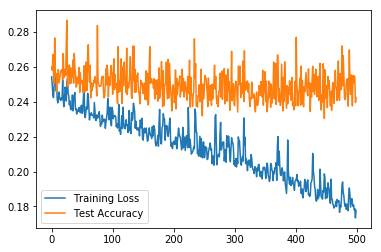

In [35]:
import matplotlib.pyplot as plt
#693/693 [==============================] - 0s 660us/step - loss: 0.0143 - val_loss: 0.0389
l_test = (history.history['val_loss'])
l_train = (history.history['loss'])
l_test = np.sqrt(history.history['val_loss'])
l_train = np.sqrt(history.history['loss'])
plt.plot(l_train, label="Training Loss")
plt.plot(l_test, label="Test Accuracy")
plt.legend()

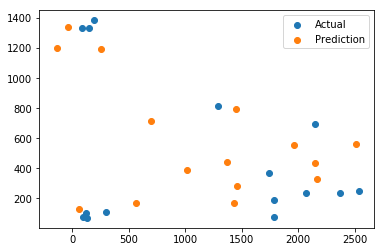

In [36]:
#model.outputs[0]
#m.outputs = 
display = [2560,1440]   
y_pred = model.predict(Input)

start = 5
end = 20
plt.scatter(y[start:end,0]*display[0],y[start:end,1]*display[1],label = "Actual")
plt.scatter(y_pred[start:end,0]*display[0],y_pred[start:end,1]*display[1], label = "Prediction")
plt.legend()

([array([ 42., 100.,  47.,  70.,  99., 153.,  72.,  40.,  80.,  68.]),
  array([ 23.,  64.,  90.,  65.,  80., 116., 110., 119.,  56.,  48.])],
 array([-0.03769255,  0.06643345,  0.17055945,  0.27468544,  0.37881145,
         0.48293746,  0.58706343,  0.69118947,  0.79531544,  0.8994415 ,
         1.0035675 ], dtype=float32),
 <a list of 2 Lists of Patches objects>)

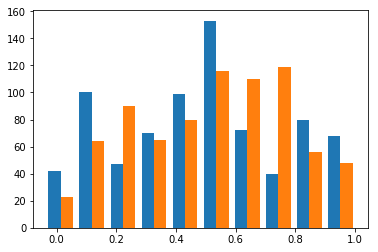

In [23]:
plt.hist(y_pred)

([array([ 75.,  84.,  38.,  82., 118., 117.,  68.,  35.,  86.,  68.]),
  array([ 43.,  75.,  91.,  51.,  73., 111., 119.,  92.,  71.,  45.])],
 array([0.00359975, 0.10314647, 0.2026932 , 0.30223992, 0.40178665,
        0.50133337, 0.6008801 , 0.70042682, 0.79997355, 0.89952027,
        0.999067  ]),
 <a list of 2 Lists of Patches objects>)

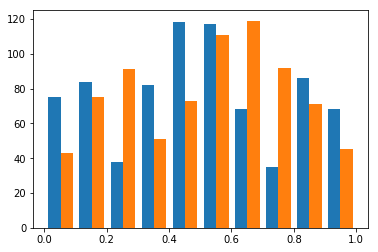

In [24]:
plt.hist(y)

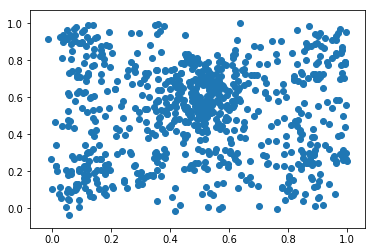

In [25]:
plt.scatter(y_pred[:,0],y_pred[:,1])

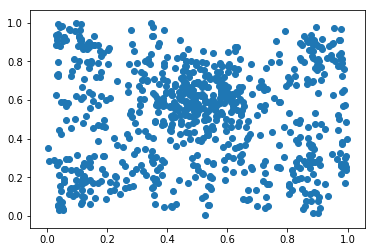

In [114]:
plt.scatter(y[:,0],y[:,1])